# Lecture 8: p-hacking and Multiple Comparisons
[J. Nathan Matias](https://github.com/natematias)
[SOC412](https://natematias.com/courses/soc412/), February 2019

In Lecture 8, we discussed Stephanie Lee's story about [Brian Wansink](https://www.buzzfeednews.com/article/stephaniemlee/brian-wansink-cornell-p-hacking#.btypwrDwe5), a food researcher who was found guilty of multiple kinds of research misconduct, including "p-hacking," where researchers keep looking for an answer until they find one. In this lecture, we will discuss what p-hacking is and what researchers can do to protect against it in our own work. 

This example uses the [DeclareDesign](http://declaredesign.org/) library, which supports the simulation and evaluation of experiment designs. We will be using DeclareDesign to help with designing experiments in this class.

What can you do in your research to protect yourself against the risk of p-hacking or against reductions in the credibility of your research if people accuse you of p-hacking?
* Conduct a **power analysis** to choose a sample size that is large enough to observe the effect you're looking for (see below)
* If you have multiple statistical tests in each experiment, [adjust your analysis for multiple comparisons](https://egap.org/methods-guides/10-things-you-need-know-about-multiple-comparisons).
* [Pre-register](https://cos.io/prereg/) your study, being clear about whether your research is exploratory or confirmatory, and committing in advance to the statistical tests you're using to analyze the results
* Use cross-validation with training and holdout samples to take an exploratory + confirmatory approach (requires a much larger sample size, typically greater than 2x)

# Load Libraries

In [2]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(corrplot)
library(Hmisc)
library(tidyverse)
library(viridis)
library(fabricatr)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))
options(repr.plot.width=7, repr.plot.height=4)

set.seed(03456920)

sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.13.0 estimatr_0.14        randomizr_0.16.1    
 [4] fabricatr_0.6.0      viridis_0.5.1        viridisLite_0.3.0   
 [7] forcats_0.3.0        stringr_1.3.1        purrr_0.2.5         
[10] readr_1.3.1          tidyr_0.8.2          tibble_2.0.0        
[13] tidyverse_1.2.1      Hmisc_4.1-1          Formula_1.2-3       
[16] survival_2.43-3      lattice_0.20-38      corrplot_0.84       
[19] rlang_0.3.0.1        ggplot2_3.1.0        MASS_7.3-51.1       
[22] dplyr_0.7.8         

l

# What is a p-value? 
A p-value (which can be calculated differently for different kinds of statistical tests) is an estimate of the probability of rejecting a null hypothesis. When testing differences in means, we are usually testing the null hypothesis of no difference between the two distributions. In those cases, the p-value is the probability of observing a difference between the distributions that is at least as extreme as the one observed.

You can think of the p-value as the probability represented by the area under the following t distribution of all of the possible outcomes for a given difference between means if the null hypothesis is true:

![title](images/null-hypothesis-test.png)

### Illustrating The Null Hypothesis
In the following case, I generate 100 sets of normal distributions with exactly the same mean and standard deviation, and then plot the differences between those means:

In [3]:
### GENERATE n.samples simulations at n.sample.size observations
### using normal distributions at the specified means
### and record the difference in means and the p value of the observations
#
# `@diff.df:       the dataframe to pass in
# `@n.sample.size: the sample sizes to draw from a normal distribution
generate.n.samples <- function(diff.df, n.sample.size = 500){
    for(i in seq(nrow(diff.df))){
        row = diff.df[i,]
        a.dist = rnorm(n.sample.size, mean = row$a.mean, sd = row$a.sd)
        b.dist = rnorm(n.sample.size, mean = row$b.mean, sd = row$a.sd)
        t <- t.test(a.dist, b.dist)

        diff.df[i,]$p.value <- t$p.value
        diff.df[i,]$mean.diff <- mean(b.dist) - mean(a.dist)
    }
    diff.df
}

In [4]:
#expand.grid
n.samples = 1000
null.hypothesis.df = data.frame(a.mean = 1, a.sd = 1, 
                                b.mean = 1, b.sd = 1,
                                id=seq(n.samples), 
                                mean.diff = NA,
                                p.value = NA)

null.hypothesis.df <- generate.n.samples(null.hypothesis.df, 200)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

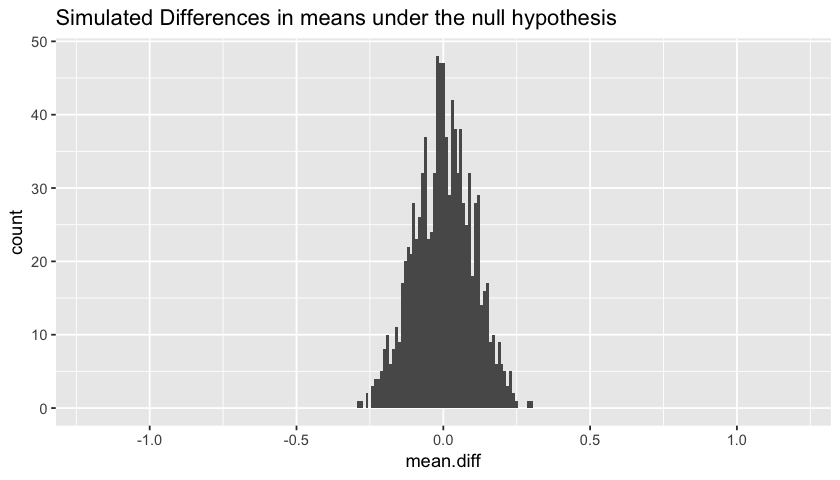

In [5]:
ggplot(null.hypothesis.df, aes(mean.diff)) +
    geom_histogram(binwidth=0.01) +
    xlim(-1.2,1.2) +
    ggtitle("Simulated Differences in means under the null hypothesis")

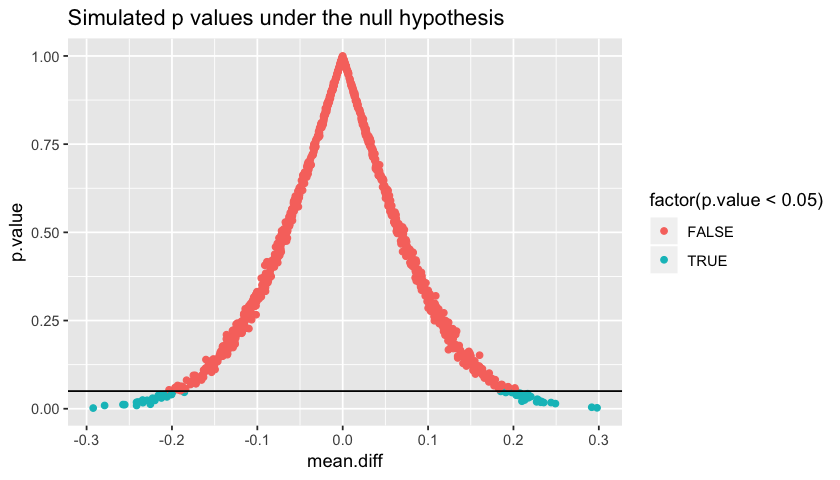

In [6]:
ggplot(null.hypothesis.df, aes(mean.diff, p.value, color=factor(p.value < 0.05))) +
    geom_point() +
    geom_hline(yintercept = 0.05) + 
    ggtitle("Simulated p values under the null hypothesis")

In [7]:
print("How often is the p-value < 0.05?")
summary(null.hypothesis.df$p.value > 0.05)

[1] "How often is the p-value < 0.05?"


   Mode   FALSE    TRUE 
logical      52     948 

### Illustrating A Difference in Means (first with a small sample size)

In [8]:
#expand.grid
small.sample.diff.df = data.frame(a.mean = 1, a.sd = 1, 
                                b.mean = 1.2, b.sd = 1,
                                id=seq(n.samples), 
                                mean.diff = NA,
                                p.value = NA)

small.sample.diff.df <- generate.n.samples(small.sample.diff.df, 20)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

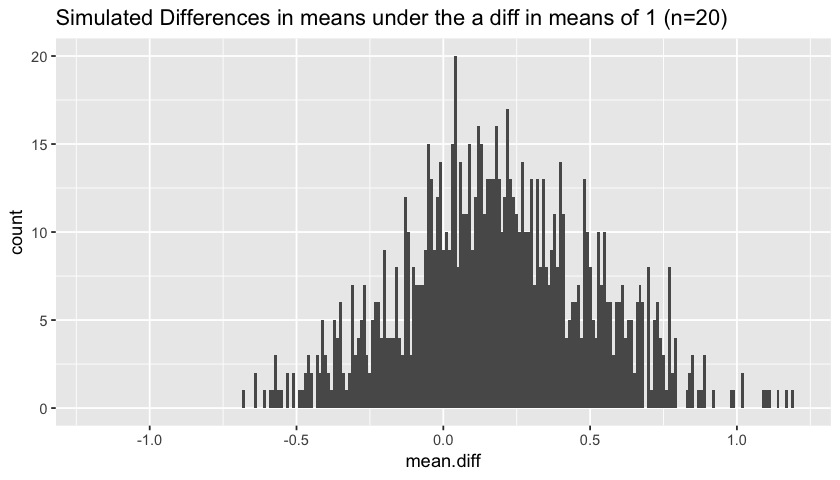

In [9]:
ggplot(small.sample.diff.df, aes(mean.diff)) +
    geom_histogram(binwidth=0.01) +
    xlim(-1.2,1.2) +
    ggtitle("Simulated Differences in means under the a diff in means of 1 (n=20)")

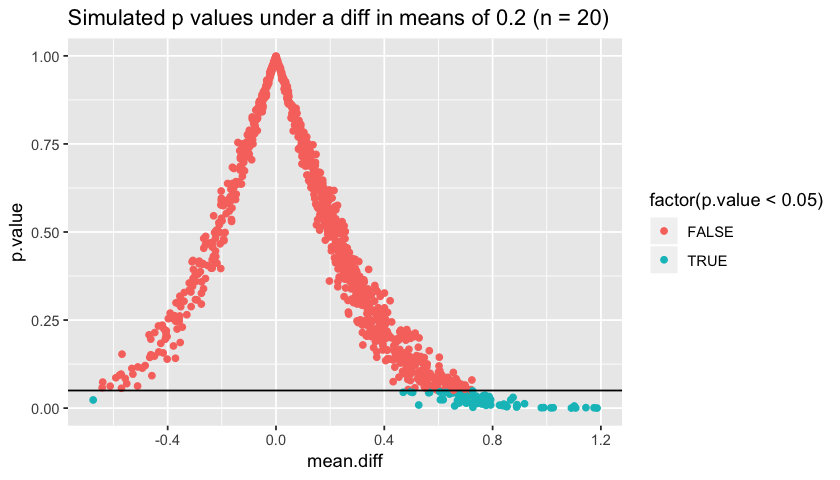

In [10]:
ggplot(small.sample.diff.df, aes(mean.diff, p.value, color=factor(p.value < 0.05))) +
    geom_point() +
    geom_hline(yintercept = 0.05) + 
    ggtitle("Simulated p values under a diff in means of 0.2 (n = 20)")

In [12]:
print("How often is the p-value < 0.05?")
summary(small.sample.diff.df$p.value > 0.05)

[1] "How often is the p-value < 0.05?"


   Mode   FALSE    TRUE 
logical      82     918 

In [13]:
print("How often is the p-value < 0.05? when the estimate is < 0 (false positive)?")
nrow(subset(small.sample.diff.df, mean.diff<0 &p.value < 0.05))

[1] "How often is the p-value < 0.05? when the estimate is < 0 (false positive)?"


[1] 1

In [14]:
print("How often is the p-value >= 0.05 when the estimate is 0.2 or greater (false negative)?")
print(sprintf("%1.2f precent", 
              nrow(subset(small.sample.diff.df, mean.diff>=0.2 &p.value >= 0.05)) / 
              nrow(small.sample.diff.df)*100))

[1] "How often is the p-value >= 0.05 when the estimate is 0.2 or greater (false negative)?"
[1] "38.70 precent"


In [15]:
print("What is the smallest positive, statistically-significant result?")
sprintf("%1.2f, which is greater than the true difference of 0.2", 
        min(subset(small.sample.diff.df, mean.diff>0 & p.value < 0.05)$mean.diff))

[1] "What is the smallest positive, statistically-significant result?"


[1] "0.47, which is greater than the true difference of 0.2"

In [16]:
print("If we only published statistically-significant results, what we would we think the true effect would be?")
sprintf("%1.2f, which is greater than the true difference of 0.2", 
        mean(subset(small.sample.diff.df, p.value < 0.05)$mean.diff))

[1] "If we only published statistically-significant results, what we would we think the true effect would be?"


[1] "0.75, which is greater than the true difference of 0.2"

In [17]:
print("If we published all experiment results, what we would we think the true effect would be?")
sprintf("%1.2f, which is very close to the true difference of 0.2", 
        mean(small.sample.diff.df$mean.diff))

[1] "If we published all experiment results, what we would we think the true effect would be?"


[1] "0.19, which is very close to the true difference of 0.2"

### Illustrating A Difference in Means (with a larger sample size)

In [24]:
#expand.grid
larger.sample.diff.df = data.frame(a.mean = 1, a.sd = 1, 
                                b.mean = 1.2, b.sd = 1,
                                id=seq(n.samples), 
                                mean.diff = NA,
                                p.value = NA)

larger.sample.diff.df <- generate.n.samples(larger.sample.diff.df, 200)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

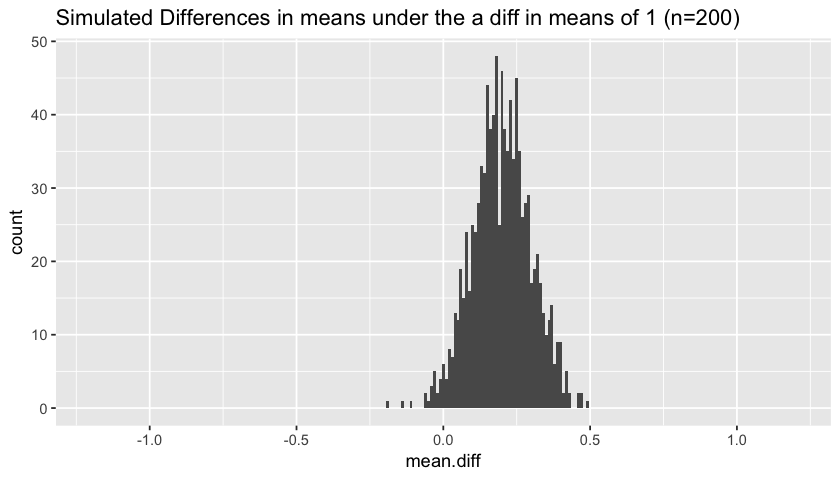

In [25]:
ggplot(larger.sample.diff.df, aes(mean.diff)) +
    geom_histogram(binwidth=0.01) +
    xlim(-1.2,1.2) +
    ggtitle("Simulated Differences in means under the a diff in means of 1 (n=200)")

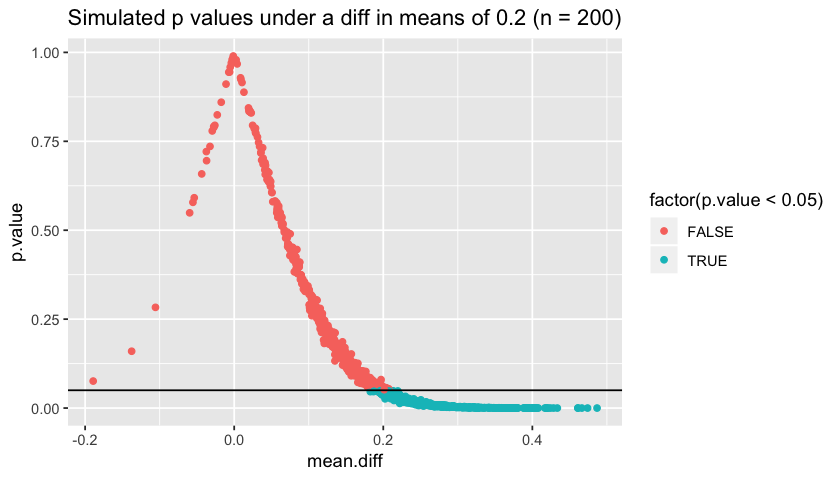

In [26]:
ggplot(larger.sample.diff.df, aes(mean.diff, p.value, color=factor(p.value < 0.05))) +
    geom_point() +
    geom_hline(yintercept = 0.05) + 
    ggtitle("Simulated p values under a diff in means of 0.2 (n = 200)")

In [27]:
print("If we only published statistically-significant results, what we would we think the true effect would be?")
sprintf("%1.2f, which is greater than the true difference of 0.2", 
        mean(subset(larger.sample.diff.df, p.value < 0.05)$mean.diff))

[1] "If we only published statistically-significant results, what we would we think the true effect would be?"


[1] "0.28, which is greater than the true difference of 0.2"

In [29]:
print("How often is the p-value < 0.05?")
sprintf("%1.2f percent", 
        nrow(subset(larger.sample.diff.df,p.value < 0.05)) / nrow(larger.sample.diff.df)*100)

[1] "How often is the p-value < 0.05?"


[1] "49.90 percent"

### Illustrating a Difference in Means (with an adequately large sample size)

In [30]:
adequate.sample.diff.df = data.frame(a.mean = 1, a.sd = 1, 
                                b.mean = 1.2, b.sd = 1,
                                id=seq(n.samples), 
                                mean.diff = NA,
                                p.value = NA)

adequate.sample.diff.df <- generate.n.samples(larger.sample.diff.df, 400)

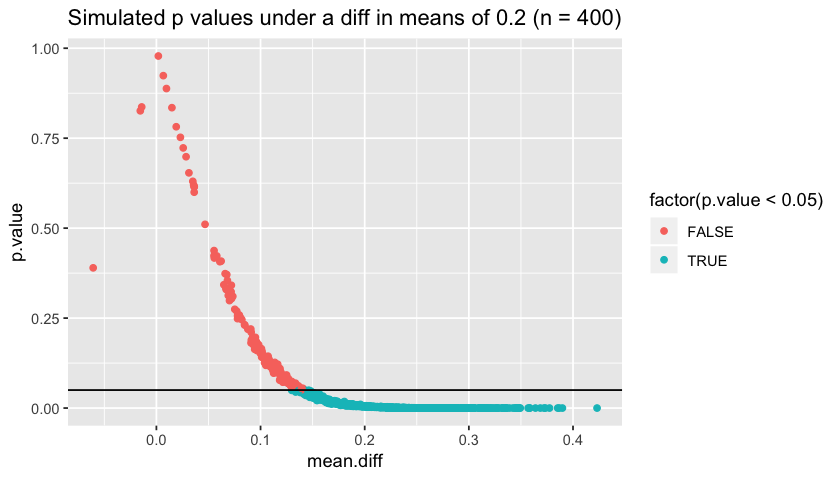

In [31]:
ggplot(adequate.sample.diff.df, aes(mean.diff, p.value, color=factor(p.value < 0.05))) +
    geom_point() +
    geom_hline(yintercept = 0.05) + 
    ggtitle("Simulated p values under a diff in means of 0.2 (n = 400)")

In [33]:
print("How often is the p-value < 0.05?")
sprintf("%1.2f percent", 
        nrow(subset(adequate.sample.diff.df,p.value < 0.05)) / nrow(adequate.sample.diff.df)*100)

[1] "How often is the p-value < 0.05?"


[1] "82.60 percent"

In [34]:
print("If we only published statistically-significant results, what we would we think the true effect would be?")
sprintf("%1.2f, which is greater than the true difference of 0.2", 
        mean(subset(adequate.sample.diff.df, p.value < 0.05)$mean.diff))

[1] "If we only published statistically-significant results, what we would we think the true effect would be?"


[1] "0.22, which is greater than the true difference of 0.2"

# The Problem of Multiple Comparisons
In the above example, I demonstrated that across 100 samples under the null hypothesis and a decision rule of p = 0.05, roughly 5% of the results are statistically significant. This is similarly true for a single experiment with multiple outcome variables.

In [35]:
## Generate n normally distributed outcome variables with no difference on average
#
#` @num.samples: sample size for the dataframe
#` @num.columns: how many outcome variables to observe
#` @common.mean: the mean of the outcomes
#` @common.sd:   the standard deviation of the outcomes

generate.n.outcomes.null <- function( num.samples, num.columns, common.mean, common.sd){
    df <- data.frame(id = seq(num.samples))
    for(i in seq(num.columns)){
        df[paste('row.',i,sep="")] <- rnorm(num.samples, mean=common.mean, sd=common.sd)
    }
    df
}

### With 10 outcome variables, if we look for correlations between every outcomes, we expect to see 5% false positives on average under the null hypothesis.

In [36]:
set.seed(487)
## generate the data
null.10.obs <- generate.n.outcomes.null(100, 10, 1, 3)
null.10.obs$id <- NULL

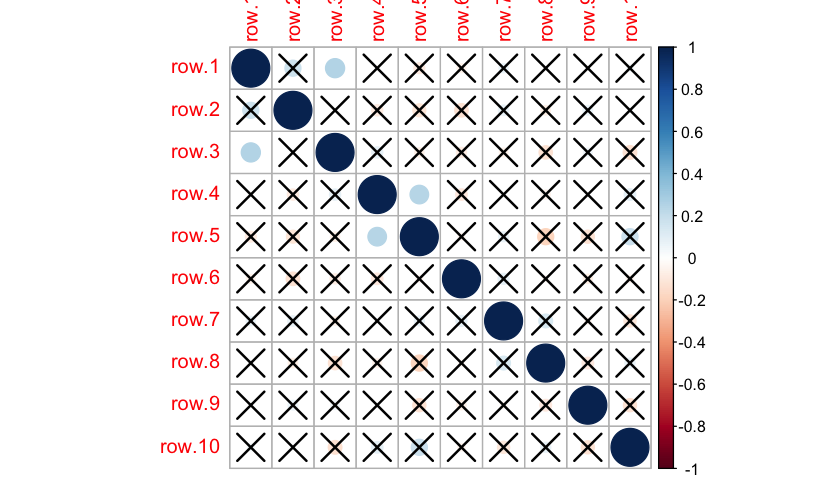

In [37]:
null.correlations <- cor(null.10.obs, method="pearson")
null.pvalues <- cor.mtest(null.10.obs, conf.level = 0.95, method="pearson")$p
corrplot(cor(null.10.obs, method="pearson"), sig.level = 0.05, p.mat = null.pvalues)

### With multiple comparisons, increasing the sample size does not make the problem go away. Here, we use a sample of 10000 instead of 100

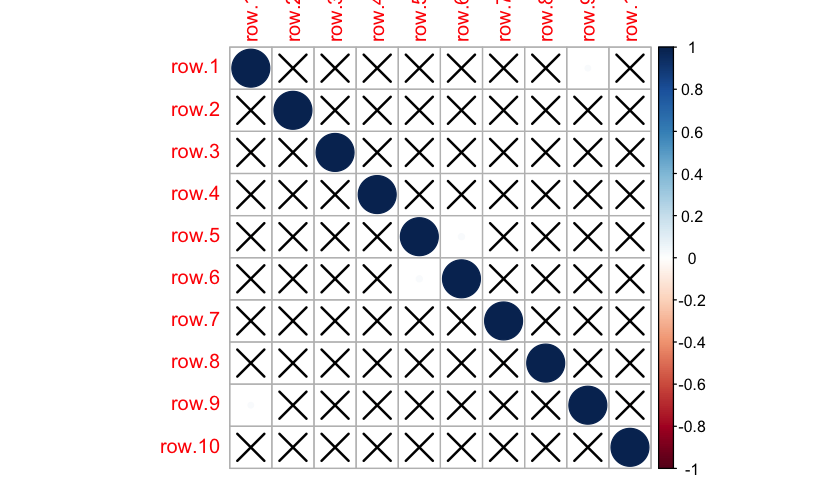

In [38]:
null.10.obs.large <- generate.n.outcomes.null(10000, 10, 1, 3)
null.10.obs.large$id <- NULL
null.correlations <- cor(null.10.obs.large, method="pearson")
null.pvalues <- cor.mtest(null.10.obs.large, conf.level = 0.95, method="pearson")$p
corrplot(cor(null.10.obs.large, method="pearson"), sig.level = 0.05, p.mat = null.pvalues)

# Power Analysis
A power analysis is a process for deciding what sample size to use based on the chance of observing the minimum effect you are looking for in your study. This power analysis uses [DeclareDesign](http://declaredesign.org/). Another option is the [egap Power Analysis page.](https://egap.org/content/power-analysis-simulations-r)

(we will discuss this in further detail in a subsequent class)

In [ ]:
mean.a   <- 0
effect.b <- 0.1
sample.size <- 500

design <-
    declare_population(
        N = sample.size
    ) +
    declare_potential_outcomes(
        YA_Z_0 = rnorm(n=N, mean = mean.a, sd=1),
        YA_Z_1 = rnorm(n=N, mean = mean.a + effect.b, sd=1)
    ) +
    declare_assignment(num_arms = 2,
                       conditions = (c("0", "1"))) +
    declare_estimand(ate_YA_1_0 = effect.b) +
    declare_reveal(outcome_variables = c("YA")) +
    declare_estimator(YA ~ Z, estimand="ate_YA_1_0")

In [ ]:
design

In [ ]:
diagnose_design(design, sims=500, bootstrap_sims=500)